In [1]:
#load necessary modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from scipy import io as matio

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Convolution2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.callbacks import TensorBoard
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

/home/sahil/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
databalanced = matio.loadmat('emnist-balanced.mat')

In [3]:
databalanced['dataset'][0][0][0][0][0][1]

array([[45],
       [36],
       [43],
       ...,
       [23],
       [31],
       [ 8]], dtype=uint8)

In [4]:
databalanced['dataset'][0][0][0][0][0][0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [5]:
height = 28 
width = 28
max_ele = len(databalanced['dataset'][0][0][0][0][0][1])
max_ele

112800

In [6]:
databalanced['dataset'][0][0][2][0][1]

48

In [8]:
mappings = {databalanced['dataset'][0][0][2][i][0]: databalanced['dataset'][0][0][2][i][1] for i in range(len(databalanced['dataset'][0][0][2]))}
mappings

{0: 48,
 1: 49,
 2: 50,
 3: 51,
 4: 52,
 5: 53,
 6: 54,
 7: 55,
 8: 56,
 9: 57,
 10: 65,
 11: 66,
 12: 67,
 13: 68,
 14: 69,
 15: 70,
 16: 71,
 17: 72,
 18: 73,
 19: 74,
 20: 75,
 21: 76,
 22: 77,
 23: 78,
 24: 79,
 25: 80,
 26: 81,
 27: 82,
 28: 83,
 29: 84,
 30: 85,
 31: 86,
 32: 87,
 33: 88,
 34: 89,
 35: 90,
 36: 97,
 37: 98,
 38: 100,
 39: 101,
 40: 102,
 41: 103,
 42: 104,
 43: 110,
 44: 113,
 45: 114,
 46: 116}

In [9]:
training_images = databalanced['dataset'][0][0][0][0][0][0][:max_ele].reshape(max_ele, height, width, 1)
training_labels = databalanced['dataset'][0][0][0][0][0][1][:max_ele]
max_ele_test = len(databalanced['dataset'][0][0][1][0][0][1])
testing_images = databalanced['dataset'][0][0][1][0][0][0][:max_ele_test].reshape(max_ele_test, height, width, 1)
testing_labels = databalanced['dataset'][0][0][1][0][0][1][:max_ele_test]
print(training_labels.T.shape, testing_labels.T.shape)

(1, 112800) (1, 18800)


In [11]:
Y_train = pd.DataFrame(training_labels)
Y_train = Y_train[0]
Y_train.value_counts()

46    2400
11    2400
20    2400
19    2400
18    2400
17    2400
16    2400
15    2400
14    2400
13    2400
12    2400
10    2400
22    2400
9     2400
8     2400
7     2400
6     2400
5     2400
4     2400
3     2400
2     2400
1     2400
21    2400
23    2400
45    2400
35    2400
44    2400
43    2400
42    2400
41    2400
40    2400
39    2400
38    2400
37    2400
36    2400
34    2400
24    2400
33    2400
32    2400
31    2400
30    2400
29    2400
28    2400
27    2400
26    2400
25    2400
0     2400
Name: 0, dtype: int64

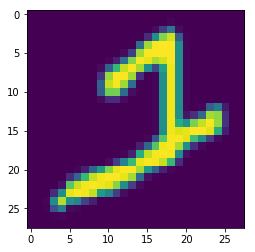

In [12]:
plt.imshow(training_images[78][:,:,0])

In [13]:
def rotate(img):
        # Used to rotate images (for some reason they are transposed on read-in)
        flipped = np.fliplr(img)
        return np.rot90(flipped)

In [14]:
for i in range(len(training_images)):
    training_images[i] = rotate(training_images[i])
for i in range(len(testing_images)):
    testing_images[i] = rotate(testing_images[i])

In [15]:
training_images = training_images.astype('float32')
testing_images = testing_images.astype('float32')

In [16]:
training_images /= 255
testing_images /= 255

4


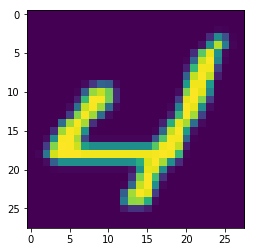

In [17]:
plt.imshow(training_images[78][:,:,0])
print(Y_train[78])

[3]


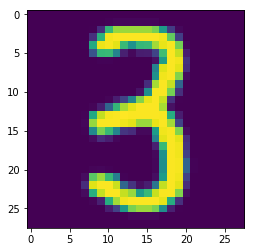

In [18]:
plt.imshow(testing_images[78][:,:,0])
print(testing_labels[78])

In [19]:
def build_model():
    # Hyperparameters
    nb_filters = 32 # number of convolutional filters to use
    pool_size = (2, 2) # size of pooling area for max pooling
    kernel_size = (3, 3) # convolution kernel size
    
    input_shape = (height, width, 1)

    model = Sequential()
    model.add(Convolution2D(nb_filters,
                            kernel_size,
                            padding='valid',
                            input_shape=input_shape,
                            activation='relu'))
    model.add(Convolution2D(nb_filters,
                            kernel_size,
                            activation='relu'))

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(mappings), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    print(model.summary())
    return model

In [20]:
model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [21]:
y_train = to_categorical(training_labels, len(mappings))
y_test = to_categorical(testing_labels, len(mappings))

In [22]:
print(y_train.shape, y_test.shape)

(112800, 47) (18800, 47)


In [23]:
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

In [24]:
model.fit(training_images, y_train,
              batch_size=256,
              epochs=10,
              verbose=1,
              validation_data=(testing_images, y_test),
              callbacks=[tbCallBack])

Train on 112800 samples, validate on 18800 samples
Epoch 1/10
112800/112800 [==============================] - 254s 2ms/step - loss: 1.1114 - acc: 0.6706 - val_loss: 0.6755 - val_acc: 0.7835
Epoch 2/10
112800/112800 [==============================] - 163s 1ms/step - loss: 0.5545 - acc: 0.8175 - val_loss: 0.5471 - val_acc: 0.8207
Epoch 3/10
112800/112800 [==============================] - 181s 2ms/step - loss: 0.4688 - acc: 0.8411 - val_loss: 0.5132 - val_acc: 0.8332
Epoch 4/10
112800/112800 [==============================] - 186s 2ms/step - loss: 0.4250 - acc: 0.8544 - val_loss: 0.4794 - val_acc: 0.8389
Epoch 5/10
112800/112800 [==============================] - 182s 2ms/step - loss: 0.3952 - acc: 0.8626 - val_loss: 0.4578 - val_acc: 0.8454
Epoch 6/10
112800/112800 [==============================] - 175s 2ms/step - loss: 0.3728 - acc: 0.8679 - val_loss: 0.4553 - val_acc: 0.8503
Epoch 7/10
112800/112800 [==============================] - 174s 2ms/step - loss: 0.3560 - acc: 0.8735 - val_

In [177]:
score = model.evaluate(testing_images, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# Offload model to file
model_yaml = model.to_yaml()
with open("bin/model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)


18800/18800 [==============================] - 10s 525us/step
Test score: 0.439156197411
Test accuracy: 0.855957446809


NameError: name 'save_model' is not defined

In [179]:
save_model(model, 'bin/model.h5')

In [192]:
prediction = model.predict(testing_images)

In [193]:
np.argmax(prediction[78])

3

In [194]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} tensorflowjs
import tensorflowjs as tfjs


Solving environment: ...working... failed



PackagesNotFoundError: The following packages are not available from current channels:

  - tensorflowjs

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/win-64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/pro/win-64
  - https://repo.anaconda.com/pkgs/pro/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




ModuleNotFoundError: No module named 'tensorflowjs'